<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Residual Distribution Analysis 
</p>

#### Core & Data Libraries

In [21]:
# SPEED HEADER (single-BLAS + joblib)
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Parallelism knob 
N_JOBS = -1

#  Core & Visualization 
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from IPython.display import display

# ML & Stats 
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

from scipy.stats import kstest, norm, t, skewnorm, cauchy, kruskal, levene
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

#  Parallel control 
from threadpoolctl import threadpool_limits
from joblib import Parallel, delayed

# Other tests 
from diptest import diptest  # Hartigan's dip

#  Utilities 
warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)

#  Notebook config toggles 
ENABLE_CO2_ANALYSIS = True       # set False to skip CO₂ terciles diagnostics
los_labels = True      # set False to skip LoS terciles diagnostics

def _seeds(base_seed: int, n: int) -> np.ndarray:
    return np.random.default_rng(base_seed).integers(0, 2**32 - 1, size=n, dtype=np.uint32)

#### Load OOF residuals + discover optional columns

LoS counts: 236180 | NLoS counts: 1179733
Detected -> residual=resid_db, fold=fold, device=device_id, los=None, fitted=PL_pred, co2=co2


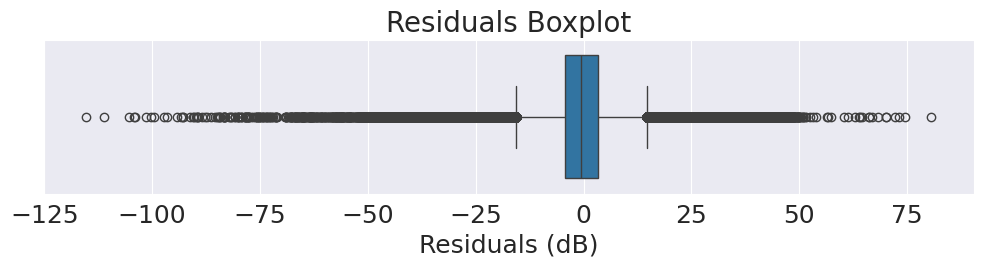

In [22]:
# load residuals 
RESID_PATH = "../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__POLY2__BEST__oof.csv"
df_res = pd.read_csv(RESID_PATH)

# detect columns 
res_candidates = ["resid_db", "residuals", "resid", "error"]
res_col = next((c for c in res_candidates if c in df_res.columns), None)
if res_col is None:
    raise KeyError(f"No residual column found; tried {res_candidates}")

col_fold = next((c for c in ["fold", "cv_fold", "group"] if c in df_res.columns), None)
col_dev  = next((c for c in ["device_id","device","ed","ED","node","Device","Node"] if c in df_res.columns), None)
col_los  = next((c for c in ["los","LoS","LOS","is_los"] if c in df_res.columns), None)
col_co2  = next((c for c in ["co2","CO2","co2_ppm","CO2_ppm"] if c in df_res.columns), None)
col_fit  = next((c for c in ["PL_pred","fitted","yhat","y_pred","pred"] if c in df_res.columns), None)

# core arrays 
residuals = df_res[res_col].astype(float).to_numpy()
n = residuals.size

#  LoS/NLoS labels (ED0 treated as LoS)
LOS_DEVICES = {"ED0"} 

if col_los is not None:
    # Use provided LoS column if present
    los_labels = df_res[col_los].astype(str).str.upper().map(lambda s: "LOS" if "LOS" in s else "NLOS")
elif col_dev is not None:
    dev_norm = df_res[col_dev].astype(str).str.strip().str.upper()
    los_set = {d.strip().upper() for d in LOS_DEVICES}
    los_labels = pd.Series(np.where(dev_norm.isin(los_set), "LOS", "NLOS"),
                           index=df_res.index, name="los")
else:
    los_labels = None

if los_labels is not None:
    df_res["los"] = los_labels
    print("LoS counts:", int((los_labels == "LOS").sum()),
          "| NLoS counts:", int((los_labels == "NLOS").sum()))

print("Detected ->",
      f"residual={res_col}, fold={col_fold}, device={col_dev}, los={col_los}, fitted={col_fit}, co2={col_co2}")

#  Q–Q prep
probabilities = (np.arange(1, n + 1) - 0.5) / n
sorted_residuals = np.sort(residuals)

#  quick outlier glimpse 
plt.figure(figsize=(12, 2))
sns.boxplot(x=residuals)
plt.xlabel("Residuals (dB)")
plt.title("Residuals Boxplot")
plt.show()

In [23]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415913 entries, 0 to 1415912
Data columns (total 20 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   model        1415913 non-null  object 
 1   split        1415913 non-null  object 
 2   row_id       1415913 non-null  int64  
 3   fold         1415913 non-null  int64  
 4   time         1415913 non-null  object 
 5   device_id    1415913 non-null  object 
 6   distance     1415913 non-null  float64
 7   frequency    1415913 non-null  float64
 8   c_walls      1415913 non-null  float64
 9   w_walls      1415913 non-null  float64
 10  co2          1415913 non-null  float64
 11  humidity     1415913 non-null  float64
 12  pm25         1415913 non-null  float64
 13  pressure     1415913 non-null  float64
 14  temperature  1415913 non-null  float64
 15  snr          1415913 non-null  float64
 16  PL_true      1415913 non-null  float64
 17  PL_pred      1415913 non-null  float64
 18  re

#### Fit Distributions (PARAMETRIC) 

In [24]:
# === Fit Distributions ===

# 1. Normal Distribution
normal_params = norm.fit(residuals)
loc_norm, scale_norm = normal_params
normal_dist = norm(loc=loc_norm, scale=scale_norm)

# 2. Skew-Normal Distribution
skew_params = skewnorm.fit(residuals)
shape_sn, loc_sn, scale_sn = skew_params
skew_dist = skewnorm(shape_sn, loc=loc_sn, scale=scale_sn)

# 3. Gaussian Mixture Model (Automated Model Selection 1 and 2)
residuals_array = residuals.reshape(-1, 1)
lowest_bic = np.inf
bic_scores = []
# up to 5 components
n_components_range = range(1, 6)
best_gmm = None

for n_components in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n_components, random_state=42).fit(residuals_array)
    bic_value = gmm_tmp.bic(residuals_array)
    bic_scores.append(bic_value)
    if bic_value < lowest_bic:
        lowest_bic = bic_value
        best_gmm = gmm_tmp

gmm = best_gmm  # Use the best GMM selected based on the lowest BIC
print(f"\nSelected GMM with {gmm.n_components} components based on lowest BIC: {lowest_bic}")

# 4. Cauchy Distribution
cauchy_params = cauchy.fit(residuals)
cauchy_dist = cauchy(*cauchy_params)

# 5. t-Distribution
t_params = t.fit(residuals)
df_t, loc_t, scale_t = t_params
t_dist = t(df=df_t, loc=loc_t, scale=scale_t)

# === Compute Log-Likelihood, AIC, BIC, and KS Test ===
def compute_aic_bic(log_likelihood, num_params, num_samples):
    """Compute AIC and BIC values."""
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_samples) - 2 * log_likelihood
    return aic, bic

# Normal Distribution
loglik_norm = np.sum(np.log(normal_dist.pdf(residuals)))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, 2, n)  # 2 params: loc, scale
ks_norm = kstest(residuals, normal_dist.cdf)

# Skew-Normal Distribution
loglik_sn = np.sum(np.log(skew_dist.pdf(residuals)))
aic_sn, bic_sn = compute_aic_bic(loglik_sn, 3, n)  # 3 params: shape, loc, scale
ks_sn = kstest(residuals, skew_dist.cdf)

# Robust GMM CDF helper (handles different covariance shapes)
def gmm_cdf(x, gmm_model):
    x = np.asarray(x)
    means = gmm_model.means_.ravel()
    covs = gmm_model.covariances_
    if covs.ndim == 3:
        covs = covs[:, 0, 0]
    elif covs.ndim == 2:
        covs = covs[:, 0]
    stds = np.sqrt(covs)
    weights = gmm_model.weights_.ravel()
    cdf = np.zeros_like(x, dtype=float)
    for w, m, s in zip(weights, means, stds):
        cdf += w * norm.cdf(x, loc=m, scale=s)
    return cdf

# Gaussian Mixture Model
# score() returns average log-likelihood; multiply by n for total
loglik_gmm = gmm.score(residuals_array) * n
# Parameter count for univariate GMM: (k-1) weights + k means + k variances = 3k - 1
aic_gmm, bic_gmm = compute_aic_bic(loglik_gmm, 3 * gmm.n_components - 1, n)
ks_gmm = kstest(residuals, lambda x: gmm_cdf(x, gmm))

# Cauchy Distribution
loglik_cauchy = np.sum(np.log(cauchy_dist.pdf(residuals)))
aic_cauchy, bic_cauchy = compute_aic_bic(loglik_cauchy, 2, n)  # 2 params: loc, scale
ks_cauchy = kstest(residuals, cauchy_dist.cdf)

# t-Distribution
loglik_t = np.sum(np.log(t_dist.pdf(residuals)))
aic_t, bic_t = compute_aic_bic(loglik_t, 3, n)  # 3 params: df, loc, scale
ks_t = kstest(residuals, t_dist.cdf)

# === Compile Diagnostics into a DataFrame ===
diagnostics = pd.DataFrame({
    'Distribution': ['Normal', 'Skew-Normal', 'Gaussian Mixture Model', 'Cauchy', 't-Distribution'],
    'Log-Likelihood': [loglik_norm, loglik_sn, loglik_gmm, loglik_cauchy, loglik_t],
    'AIC': [aic_norm, aic_sn, aic_gmm, aic_cauchy, aic_t],
    'BIC': [bic_norm, bic_sn, bic_gmm, bic_cauchy, bic_t],
    'KS Test Statistic': [ks_norm.statistic, ks_sn.statistic, ks_gmm.statistic, ks_cauchy.statistic, ks_t.statistic],
    'KS Test p-value': [ks_norm.pvalue, ks_sn.pvalue, ks_gmm.pvalue, ks_cauchy.pvalue, ks_t.pvalue]
})

diagnostics['Log-Likelihood'] = diagnostics['Log-Likelihood'].round(2)
diagnostics['AIC'] = diagnostics['AIC'].round(2)
diagnostics['BIC'] = diagnostics['BIC'].round(2)
diagnostics['KS Test Statistic'] = diagnostics['KS Test Statistic'].round(4)
diagnostics['KS Test p-value'] = diagnostics['KS Test p-value'].round(4)

print("\nDiagnostics Table:")
display(diagnostics)

best_fit = diagnostics.loc[diagnostics['KS Test Statistic'].idxmin()]
print(f"\nBest Fit (Based on KS Test Statistic): {best_fit['Distribution']}\n")


Selected GMM with 3 components based on lowest BIC: 9290363.941447116

Diagnostics Table:


,Distribution,Log-Likelihood,AIC,BIC,KS Test Statistic,KS Test p-value
0,Normal,-4798409.50,9596823.00,9596847.33,0.0716,0.0
1,Skew-Normal,-4763908.35,9527822.70,9527859.19,0.0603,0.0
2,Gaussian Mixture Model,-4645125.32,9290266.64,9290363.94,0.0094,0.0
3,Cauchy,-4811951.23,9623906.47,9623930.79,0.0771,0.0
4,t-Distribution,-4663327.73,9326661.47,9326697.96,0.0270,0.0



Best Fit (Based on KS Test Statistic): Gaussian Mixture Model



#### GMM Diagnostics (1–5 components)

In [25]:
# Convert residuals to a 2D array for GMM (required shape: [n_samples, n_features])
gmm_models = []  # Define and initialize the list

# Initialize a list to store diagnostics for each GMM with different numbers of components
gmm_diagnostics = []

# Loop over the number of components (1 through 5)
for k in range(1, 6):
    # Fit GMM with k components using a fixed random state for reproducibility
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)
    
    # Calculate the total log-likelihood from the per-sample log probabilities.
    # Note: score_samples returns the log probability for each sample.
    loglik_k = np.sum(gmm_k.score_samples(residuals_array))
    
    # Estimate the number of free parameters for a mixture of Gaussians.
    # For each component: 1 weight (but total weights sum to 1: hence, k - 1 free parameters),
    # 1 mean, and 1 variance. Total parameters: (k - 1) + k + k = 3k - 1.
    num_params = 3 * k - 1
    
    # Compute AIC and BIC using standard formulas:    
    aic_k = 2 * num_params - 2 * loglik_k
    bic_k = num_params * np.log(len(residuals_array)) - 2 * loglik_k
    
    # Perform a Kolmogorov–Smirnov (KS) test on the residuals versus the GMM cumulative distribution.
    # We use our custom gmm_cdf function defined earlier.
    ks_result = kstest(residuals, lambda x: gmm_cdf(x, gmm_k))
    
    # Append the diagnostics for the current model to our list
    gmm_diagnostics.append({
        'GMM Components': k,
        'Log-Likelihood': loglik_k,
        'AIC': aic_k,
        'BIC': bic_k,
        'KS Statistic': ks_result.statistic,
        'KS p-value': ks_result.pvalue
    })

# Convert the collected diagnostics to a DataFrame
gmm_diag_df = pd.DataFrame(gmm_diagnostics)

print("\n=== GMM Diagnostics (Modes 1-5) ===\n")
display(gmm_diag_df)

# Select the best GMM based on the minimum AIC value (or BIC)
best_gmm_row = gmm_diag_df.loc[gmm_diag_df['BIC'].idxmin()]
best_gmm_components = best_gmm_row['GMM Components']
best_gmm = gmm_models[int(best_gmm_components) - 1]
print(f"\nBest GMM Model based on lowest BIC: {int(best_gmm_components)} components\n")


=== GMM Diagnostics (Modes 1-5) ===



,GMM Components,Log-Likelihood,AIC,BIC,KS Statistic,KS p-value
0,1,-4.798410e+06,9.596823e+06,9.596847e+06,0.071581,0.000000e+00
1,2,-4.654015e+06,9.308039e+06,9.308100e+06,0.010509,2.932771e-136
2,3,-4.645125e+06,9.290267e+06,9.290364e+06,0.009402,3.926269e-109
3,4,-4.645486e+06,9.290994e+06,9.291128e+06,0.015997,3.748693e-315
4,5,-4.651692e+06,9.303411e+06,9.303582e+06,0.008423,1.114554e-87



Best GMM Model based on lowest BIC: 3 components



#### Q–Q Plots for GMMs + Histogram Overlay

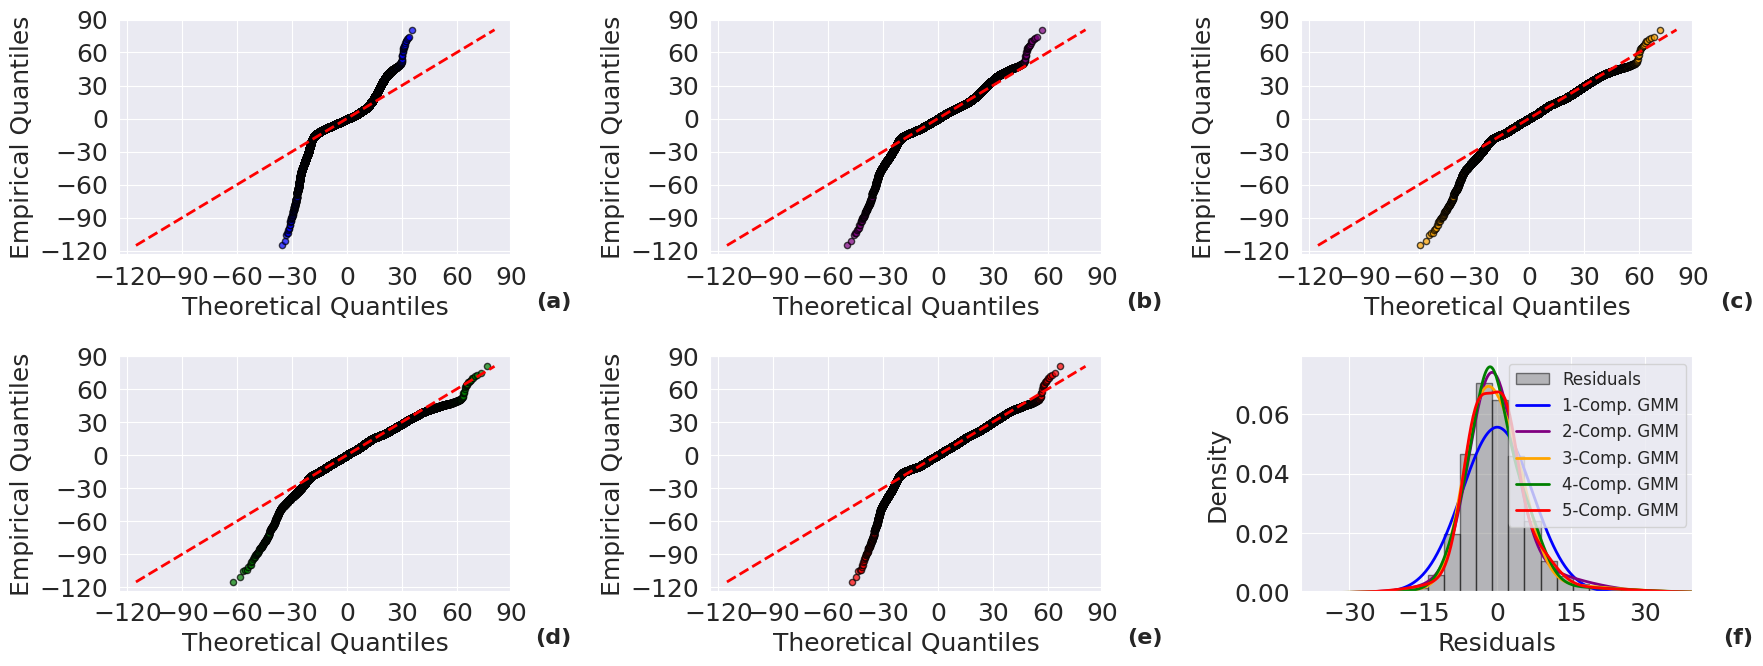

In [26]:
# --- Re-fit GMM models for 1 to 5 components and store them in a list ---
gmm_models = []
for k in range(1, 6):
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)

# Prepare sorted residuals and the corresponding probability positions
sorted_residuals = np.sort(residuals)
n = len(sorted_residuals)
probs = (np.arange(1, n + 1) - 0.5) / n  # Probability positions for quantiles

# --- Create a 2x3 grid for Q–Q plots and the combined histogram ---
fig, axes = plt.subplots(2, 3, figsize=(18, 7))
axes = axes.flatten()
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
gmm_colors = ['blue', 'purple', 'orange', 'green', 'red']

# --- Plot Q–Q plots for each of the 5 GMM models ---
for i, gmm_model in enumerate(gmm_models):
    ax = axes[i]
    
    # Generate a dense grid to compute the GMM CDF
    x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
    cdf_grid = gmm_cdf(x_grid, gmm_model)
    
    # Remove duplicate CDF values for reliable interpolation
    unique_cdf, unique_idx = np.unique(cdf_grid, return_index=True)
    unique_x = x_grid[unique_idx]
    # Create an interpolation function (PPF) from CDF to quantiles
    ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
    theoretical_quantiles = ppf_func(probs)
    
    # Scatter the theoretical versus empirical quantiles
    ax.scatter(theoretical_quantiles, sorted_residuals, color=gmm_colors[i], alpha=0.7, edgecolors='k', s=20)
    # Plot a 45° reference line
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    ax.set_xlabel('Theoretical Quantiles', fontsize=18)
    ax.set_ylabel('Empirical Quantiles', fontsize=18)
    #ax.set_title(f'GMM with {i+1} Component(s)', fontsize=20)
    ax.text(1.15, -0.15, subplot_labels[i], transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)
    ax.grid(True)

# --- Plot the 6th subplot: Histogram of residuals with overlaid GMM densities ---
ax6 = axes[5]
ax6.hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
for i, gmm_model in enumerate(gmm_models):
    # Compute the density for the current GMM (exponentiate the log probabilities)
    density = np.exp(gmm_model.score_samples(x_vals.reshape(-1, 1)))
    ax6.plot(x_vals, density, color=gmm_colors[i], linewidth=2, label=f'{i+1}-Comp. GMM')
    
ax6.set_xlabel('Residuals', fontsize=18)
ax6.set_ylabel('Density', fontsize=18)
ax6.legend(fontsize=12)
ax6.set_xlim(-40, 40)
ax6.grid(True)
ax6.text(1.15, -0.15, subplot_labels[5], transform=ax6.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)

# Set tick intervals and font sizes
for i, ax in enumerate(axes):
    if i < 5:  # Subplots (a) to (e)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.yaxis.set_major_locator(MultipleLocator(30))
    elif i == 5:  # Subplot (f)
        ax.xaxis.set_major_locator(MultipleLocator(15))
    
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(3)
        
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/gmm_qq_residual_plots.png', dpi=1000)
plt.show()

#### Print Distribution Parameters

In [27]:
# --- Print Distribution Parameters Including Best GMM ---

def print_group(title, params):
    bold_title = f"\033[1m=== {title} ===\033[0m"
    print(bold_title)
    for name, val in params:
        print(f"{name}: {val:.4f}")
    print("-" * 50)

# Normal Distribution
print_group("Normal Distribution", [("Mean (μ)", loc_norm), ("Std (σ)", scale_norm)])

# Skew-Normal Distribution
print_group("Skew-Normal Distribution", [("Shape", shape_sn), ("Location", loc_sn), ("Scale", scale_sn)])

# Gaussian Mixture Model (Using Best GMM from Diagnostics)
bold_title = f"\033[1m=== Gaussian Mixture Model (Best GMM) ===\033[0m"
print(bold_title)
for i in range(best_gmm.n_components):
    print(f"Component {i+1}:")
    print(f"  Weight (π): {best_gmm.weights_[i]:.4f}")
    if best_gmm.covariances_.ndim == 3:
        std = np.sqrt(best_gmm.covariances_[i][0][0])
    else:
        std = np.sqrt(best_gmm.covariances_[i])
    mean = best_gmm.means_[i][0]
    print(f"  Mean (μ):   {mean:.4f}")
    print(f"  Std (σ):    {std:.4f}")
print("-" * 50)

# Cauchy Distribution
print_group("Cauchy Distribution", [("Location", cauchy_params[0]), ("Scale", cauchy_params[1])])

# t-Distribution
print_group("t-Distribution", [("Degrees of Freedom (df)", df_t), ("Location", loc_t), ("Scale", scale_t)])

=== Normal Distribution ===
Mean (μ): 0.0000
Std (σ): 7.1705
--------------------------------------------------
=== Skew-Normal Distribution ===
Shape: 1.5531
Location: -6.2628
Scale: 9.5204
--------------------------------------------------
=== Gaussian Mixture Model (Best GMM) ===
Component 1:
  Weight (π): 0.4214
  Mean (μ):   2.4976
  Std (σ):    4.1665
Component 2:
  Weight (π): 0.4645
  Mean (μ):   -3.7510
  Std (σ):    3.7710
Component 3:
  Weight (π): 0.1142
  Mean (μ):   6.0429
  Std (σ):    14.5490
--------------------------------------------------
=== Cauchy Distribution ===
Location: -0.8231
Scale: 3.5021
--------------------------------------------------
=== t-Distribution ===
Degrees of Freedom (df): 3.7632
Location: -0.5691
Scale: 4.9261
--------------------------------------------------


#### Diagnostic Subplots 2×3 (Normal, Skew, best GMM, Cauchy, t, Histogram)

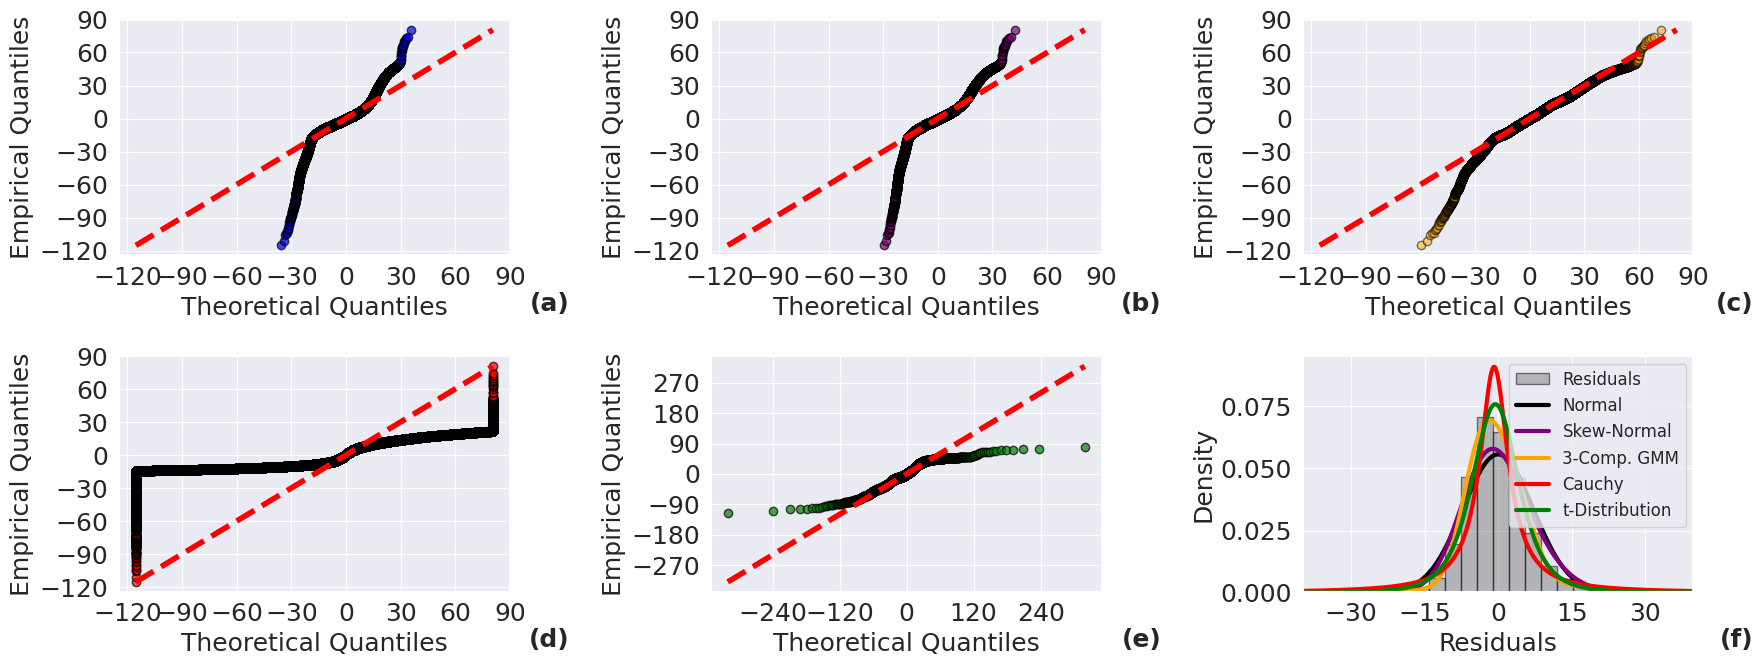

In [28]:
# === Plot Diagnostic Subplots in a 2x3 Grid ===
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'legend.fontsize': 15
})

fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Define subplot labels for the six subplots
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Function to create manual Q-Q plots
def manual_qq_plot(distribution, dist_name, sorted_residuals, probabilities, ax, color='blue'):
    """
    Create a manual Q-Q plot.
    """
    theoretical_quantiles = distribution.ppf(probabilities)
    ax.scatter(theoretical_quantiles, sorted_residuals, edgecolors='k', facecolor=color, alpha=0.7)
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
    #ax.set_title(f'{dist_name} Distribution')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Empirical Quantiles')
    ax.grid(True)

# 1. Q-Q Plot (Normal Distribution)
manual_qq_plot(normal_dist, 'Normal', sorted_residuals, probabilities, axes[0], color='blue')
axes[0].text(1.15, -0.15, subplot_labels[0], transform=axes[0].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 2. Q-Q Plot (Skew-Normal Distribution)
manual_qq_plot(skew_dist, 'Skew-Normal', sorted_residuals, probabilities, axes[1], color='purple')
axes[1].text(1.15, -0.15, subplot_labels[1], transform=axes[1].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 3. Q-Q Plot (Gaussian Mixture Model)
x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
cdf_grid = gmm_cdf(x_grid, best_gmm)  # Using best_gmm here
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]
ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
theoretical_gmm_quantiles = ppf_func(probabilities)

axes[2].scatter(theoretical_gmm_quantiles, sorted_residuals, edgecolors='k', facecolor='orange', alpha=0.5)
min_val = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
max_val = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
#axes[2].set_title('GMM Distribution')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Empirical Quantiles')
axes[2].grid(True)
axes[2].text(1.15, -0.15, subplot_labels[2], transform=axes[2].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 4. Q-Q Plot (Cauchy Distribution)
lower_bound = residuals.min()
upper_bound = residuals.max()
theoretical_quantiles = cauchy_dist.ppf(probabilities)
theoretical_quantiles_clipped = np.clip(theoretical_quantiles, lower_bound, upper_bound)

axes[3].scatter(theoretical_quantiles_clipped, sorted_residuals, edgecolors='k', facecolor='red', alpha=0.7)
axes[3].plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'r--', linewidth=4)
#axes[3].set_title('Cauchy Distribution')
axes[3].set_xlabel('Theoretical Quantiles')
axes[3].set_ylabel('Empirical Quantiles')
axes[3].grid(True)
axes[3].text(1.15, -0.15, subplot_labels[3], transform=axes[3].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 5. Q-Q Plot (t-Distribution)
manual_qq_plot(t_dist, 't-', sorted_residuals, probabilities, axes[4], color='green')
axes[4].text(1.15, -0.15, subplot_labels[4], transform=axes[4].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 6. Residuals Histogram with Fitted Densities
axes[5].hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[5].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='black', linewidth=3)
axes[5].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=3)
# Using best_gmm to compute density
gmm_density = np.exp(best_gmm.score_samples(x_vals.reshape(-1, 1)))
axes[5].plot(x_vals, gmm_density, label=f'{best_gmm.n_components}-Comp. GMM', color='orange', linewidth=3)
axes[5].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=3)
axes[5].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='green', linewidth=3)
#axes[5].set_title('Residuals Distributions')
axes[5].set_xlabel('Residuals')
axes[5].set_ylabel('Density')
axes[5].legend(fontsize=12)
axes[5].grid(True)
axes[5].set_xlim(-40, 40)
axes[5].text(1.15, -0.15, subplot_labels[5], transform=axes[5].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# ----- Tick Interval Adjustments  -----
# For subplots a-d (axes[0] to axes[3]), 30
for i in range(0, 4):
    axes[i].xaxis.set_major_locator(MultipleLocator(30))
    axes[i].yaxis.set_major_locator(MultipleLocator(30))

# For subplot e (axes[4]), 60
axes[4].xaxis.set_major_locator(MultipleLocator(120))
axes[4].yaxis.set_major_locator(MultipleLocator(90))

# For histogram subplot f (axes[5]), 15
axes[5].xaxis.set_major_locator(MultipleLocator(15))
# ----- End of Tick Interval Adjustments -----

# Adjust tick font size for all subplots
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=18)

# Set all subplot border widths (spines) to 3 
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(3)

# Adjust layout, save figure, and display
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/qq_residual_plots.png', dpi=1500)
plt.show()

#### Non-parametric residual diagnostics

In [29]:
# Fast KDE + modality diagnostics (Silverman + dip + modes vs. h)
# Memory-safe; avoids O(B * H) sklearn fits by using FFT KDE on a
# fixed grid and reusing Gaussian kernels across bootstraps.
#----------------------------------------------------------------------

# Configuration
N_JOBS   = -1              # use all cores (joblib)
SEED     = 42              # reproducibility
PROM_REL = 5e-3            # peak prominence as fraction of KDE range
REPORT_XLIM = (-30, 30)    # plotting window for residual PDFs


rng = np.random.default_rng(SEED)


# Utilities
def _seeds(seed: int, B: int) -> np.ndarray:
    return np.random.default_rng(seed).integers(0, 2**32 - 1, size=B, dtype=np.uint32)

def silverman_bw(x: np.ndarray) -> float:
    x = np.asarray(x).ravel()
    sigma = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    s = min(sigma, iqr / 1.349) if np.isfinite(iqr) and iqr > 0 else sigma
    return 0.9 * s * (x.size ** (-1/5))

def make_grid(x: np.ndarray, xlim=None, n: int = 1201) -> np.ndarray:
    """Uniform grid for FFT-KDE; default wide enough and odd length (nice for symmetry)."""
    x = np.asarray(x, float).ravel()
    if xlim is None:
        lo, hi = np.percentile(x, [0.1, 99.9])
        pad = 0.05 * (hi - lo)
        lo -= pad; hi += pad
    else:
        lo, hi = xlim
    return np.linspace(lo, hi, n, dtype=np.float64)

def _gaussian_kernel_fft(n_bins: int, dx: float, h: float) -> np.ndarray:
    """FFT of a discrete Gaussian kernel (sum=1)."""
    m = max(1, int(np.ceil(5.0 * h / dx)))     # ~±5σ support
    t = np.arange(-m, m + 1) * dx
    k = np.exp(-0.5 * (t / h) ** 2)
    k /= k.sum()                                # discrete normalization
    k_padded = np.pad(k, (0, max(0, n_bins - k.size)))
    return np.fft.rfft(k_padded[:n_bins])

def kde_fft_on_grid(x: np.ndarray, h: float, grid: np.ndarray) -> np.ndarray:
    """Fast Gaussian KDE via histogram FFT on a fixed grid."""
    dx = float(grid[1] - grid[0])
    edges = np.concatenate([grid - dx / 2.0, [grid[-1] + dx / 2.0]])
    counts, _ = np.histogram(x, bins=edges)
    n_bins = counts.size
    K = _gaussian_kernel_fft(n_bins, dx, h)
    C = np.fft.rfft(counts)
    y = np.fft.irfft(C * K, n_bins)
    return (y / (x.size * dx)).astype(np.float64)  # density

def kde_on_grid_sklearn(x: np.ndarray, h: float, grid: np.ndarray) -> np.ndarray:
    """Reference (slower) KDE using sklearn for display-only curves."""
    km = KernelDensity(kernel="gaussian", bandwidth=float(h)).fit(x.reshape(-1, 1))
    return np.exp(km.score_samples(grid.reshape(-1, 1)))

def count_modes_y(y: np.ndarray, rel_prom: float = PROM_REL, abs_prom: float = 0.0) -> int:
    prom = max(abs_prom, rel_prom * float(y.max() - y.min()))
    peaks, _ = find_peaks(y, prominence=prom)
    return int(peaks.size)

def cvll_bandwidth(x: np.ndarray, h_cand: np.ndarray, n_splits: int = 3,
                   n_sub: int = 100_000, seed: int = 42, n_jobs: int = -1) -> float:
    """Cross-validated log-likelihood (on subsample) for a display/diagnostic bandwidth."""
    x = np.asarray(x, float).ravel()
    if x.size > n_sub:
        x = np.random.default_rng(seed).choice(x, size=n_sub, replace=False)
    X = x.reshape(-1, 1)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def score_h(h):
        with threadpool_limits(1):
            ll = 0.0
            for tr, va in kf.split(X):
                kde = KernelDensity(kernel="gaussian", bandwidth=float(h)).fit(X[tr])
                ll += kde.score(X[va])
            return h, ll

    out = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(score_h)(float(h)) for h in h_cand)
    return float(max(out, key=lambda t: t[1])[0])

def modes_vs_bandwidth(x: np.ndarray, h0: float, grid: np.ndarray,
                       octaves: int = 4, K: int = 33, rel_prom: float = PROM_REL,
                       n_jobs: int = -1):
    """Mode count along a logarithmic bandwidth sweep (FFT-KDE)."""
    hs = h0 * (2.0 ** np.linspace(-octaves, +octaves, K))
    def one(h):
        with threadpool_limits(1):
            y = kde_fft_on_grid(x, h, grid)
            return float(h), count_modes_y(y, rel_prom=rel_prom)
    out = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(one)(float(h)) for h in hs)
    hs2, ms = zip(*out)
    return np.array(hs2), np.array(ms, int)

def silverman_crit_unimodal_adaptive_fast(
    x: np.ndarray, alpha_modes: int = 1, B: int = 199, grid: np.ndarray = None,
    rel_prom: float = PROM_REL, seed: int = 42, n_jobs: int = -1
):
    """
    Silverman critical bandwidth (≤ alpha_modes) with smoothed bootstrap p-value,
    implemented with FFT-KDE for >100x speed-up. Mirrors your slow routine.
    """
    x = np.asarray(x, float).ravel()
    if grid is None:
        grid = make_grid(x)

    h0 = silverman_bw(x)

    # --- enlarge grid to avoid bootstrap mass leaking outside edges ---
    dx = float(grid[1] - grid[0])
    span = float(grid[-1] - grid[0])
    pad = max(6.0 * h0, 0.10 * span)
    n_extra = int(np.ceil(pad / dx))
    grid_big = np.linspace(grid[0] - n_extra * dx, grid[-1] + n_extra * dx,
                           grid.size + 2 * n_extra, dtype=np.float64)

    # bandwidth search grid (adaptive)
    h_grid = h0 * (2.0 ** np.linspace(-4, +4, 41))

    def modes_for(h, arr):
        y = kde_fft_on_grid(arr, float(h), grid_big)
        return count_modes_y(y, rel_prom=rel_prom)

    # find h* such that KDE becomes unimodal; ensure interior point by expansion
    while True:
        obs_modes = [modes_for(h, x) for h in h_grid]
        try:
            hcrit = next(float(h) for h, m in zip(h_grid, obs_modes) if m <= alpha_modes)
        except StopIteration:
            # still multimodal at the top; expand upward
            h_grid = np.concatenate([h_grid, h_grid[-1] * 2.0 ** np.arange(1, 6)])
            continue
        if hcrit < h_grid[-2]:   # interior enough
            break
        h_grid = h_grid * 2.0

    # --- smoothed bootstrap using FFT reuse ---
    # Precompute FFT Gaussian kernels for *all* candidate h on this grid
    dxb = float(grid_big[1] - grid_big[0])
    edges = np.concatenate([grid_big - dxb / 2.0, [grid_big[-1] + dxb / 2.0]])
    # base histogram of x to set sizes
    base_counts, _ = np.histogram(x, bins=edges)
    n_bins = base_counts.size

    K_list = [_gaussian_kernel_fft(n_bins, dxb, float(h)) for h in h_grid]
    seeds = _seeds(seed, B)
    n = x.size

    def hcrit_for_hist(counts_1d: np.ndarray) -> float:
        C = np.fft.rfft(counts_1d.astype(np.float64, copy=False))
        for hh, K in zip(h_grid, K_list):
            y = np.fft.irfft(C * K, n_bins) / (n * dxb)
            if count_modes_y(y, rel_prom=rel_prom) <= alpha_modes:
                return float(hh)
        return float(h_grid[-1])

    def one_boot(s):
        with threadpool_limits(1):  # prevent nested BLAS threads
            r = np.random.default_rng(int(s))
            xb = x[r.integers(0, n, n)] + hcrit * r.standard_normal(n)
            bc, _ = np.histogram(xb, bins=edges)
            return hcrit_for_hist(bc)

    hb = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(one_boot)(int(s)) for s in seeds)
    hb = np.asarray(hb, float)

    # Silverman p-value: proportion of bootstrap h* <= observed h*
    pval = (np.sum(hb <= hcrit) + 1) / (B + 1)

    return float(hcrit), float(pval), grid_big
# ------------------ /Utilities ------------------


# RUN THE SUITE
# We expect a 1-D array/Series named `residuals` in scope.
try:
    x = np.asarray(residuals, dtype=float).ravel()
except NameError as e:
    raise RuntimeError("Please define `residuals` as a 1-D array of residuals (in dB).") from e

# 1) Common grids
x_grid = make_grid(x, xlim=REPORT_XLIM, n=1201)

# 2) Reference & descriptive bandwidths
h_silv = silverman_bw(x)
h_cand = h_silv * (2.0 ** np.linspace(-2, +2, 13))
h_cvll = cvll_bandwidth(x, h_cand, n_splits=3, n_sub=100_000, seed=SEED, n_jobs=N_JOBS)

# 3) KDE curves (display only)
y_silv = kde_on_grid_sklearn(x, h_silv, x_grid)  # reference
y_cvll = kde_on_grid_sklearn(x, h_cvll, x_grid)  # reference

# 4) Dip (sensitivity) and Silverman (inference) — FAST
dip_d, dip_p = diptest(x)
hcrit, p_silv, grid_big = silverman_crit_unimodal_adaptive_fast(
    x, alpha_modes=1, B=199, grid=x_grid,
    rel_prom=PROM_REL, seed=SEED, n_jobs=N_JOBS
)

print(f"[Dip]       dip={dip_d:.6f}, p={dip_p:.4g}")
print(f"[Silverman] h*={hcrit:.5f}, p={p_silv:.4f}  (H0: ≤1 mode)")
print(f"[KDE bw]    Silverman={h_silv:.3f}, CV-LL={h_cvll:.3f}  (display only)")

# 5) Modes vs bandwidth (FFT-KDE)
hs, ms = modes_vs_bandwidth(
    x, h0=h_silv, grid=grid_big, octaves=4, K=33,
    rel_prom=PROM_REL, n_jobs=N_JOBS
)

[Dip]       dip=0.004243, p=0
[Silverman] h*=1.03518, p=1.0000  (H0: ≤1 mode)
[KDE bw]    Silverman=0.297, CV-LL=0.944  (display only)


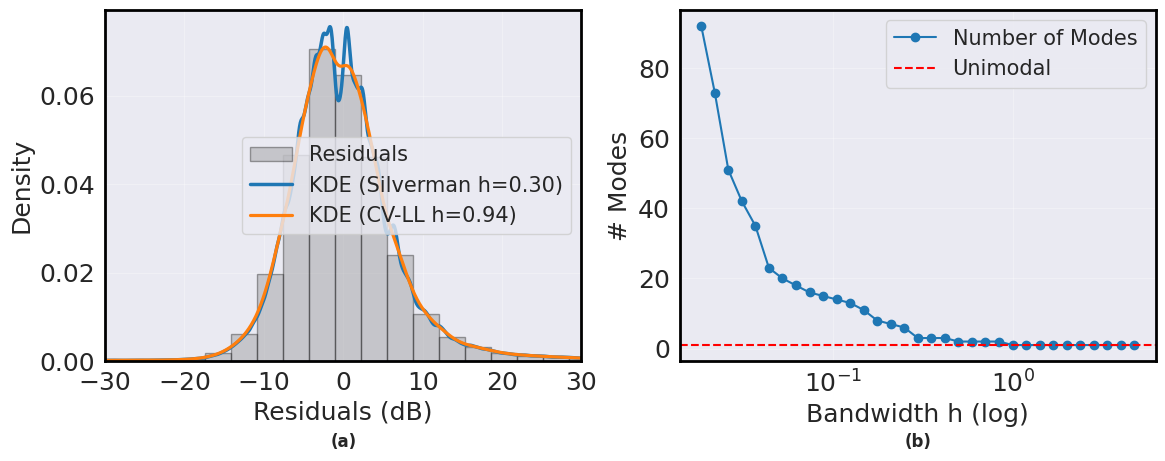

In [30]:
# PLOTTING 
sns.set_style("darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: histogram + KDEs
axes[0].hist(x, bins=60, density=True, alpha=0.35, color='grey',
             edgecolor='black', label='Residuals')
axes[0].plot(x_grid, y_silv, lw=2.5, label=f'KDE (Silverman h={h_silv:.2f})')
axes[0].plot(x_grid, y_cvll, lw=2.3, label=f'KDE (CV-LL h={h_cvll:.2f})')
axes[0].set_xlim(x_grid[0], x_grid[-1])
#axes[0].set_title('Residual KDE')
axes[0].set_xlabel('Residuals (dB)')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Right: modes vs bandwidth
axes[1].plot(hs, ms, marker='o', label='Number of Modes')
axes[1].axhline(1, color='r', ls='--', lw=1.5, label='Unimodal')
axes[1].set_xscale('log')
#axes[1].set_title('Number of modes vs bandwidth')
axes[1].set_xlabel('Bandwidth h (log)')
axes[1].set_ylabel('# Modes')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Make subplot borders (spines) thick and black
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_edgecolor("black")

# --- layout + panel labels below subplots ---
plt.tight_layout(rect=[0, 0.10, 1, 1])
fig.subplots_adjust(bottom=0.16)   # then, make room at the bottom

# center under each axis in figure coords
for i, ax in enumerate(axes):
    bb = ax.get_position()
    xc = 0.5 * (bb.x0 + bb.x1)
    fig.text(xc, 0.0, f"({chr(97+i)})",
             ha='center', va='top', fontsize=12, fontweight='bold')
# --------------------------------------------

os.makedirs("Reports/KDE", exist_ok=True)
# save without cropping
plt.savefig("../Extended Parametric Regression Files+Plots/residual_kde__and__modes_vs_bw__side_by_side.png",
            dpi=2000, bbox_inches="tight", pad_inches=0.02)
plt.show()
plt.show()

####  Non-parametric group diagnostics (with effect sizes)

In [31]:
# KW (location) & Brown–Forsythe (scale)
# Full-sample, deterministic tests. No subsampling, no bootstraps, no options.

def _mad(a: np.ndarray) -> float:
    """Median absolute deviation (robust scale)."""
    m = np.median(a)
    return float(np.median(np.abs(a - m)))

def _clean_group(g):
    """1D float array with non-finite values removed."""
    g = np.asarray(g, float).ravel()
    return g[np.isfinite(g)]

def run_kw_bf_exact(name: str, groups):
    """
    Exact group diagnostics on full data:
      • Kruskal–Wallis (location; rank-based; invariant to monotone transforms).
      • Brown–Forsythe (scale; Levene centered at median; robust to outliers).
    Effect sizes (reporting, not test statistics):
      • KW epsilon^2 = max(0, (H − (k−1)) / (N − k))
      • BF eta^2     = (F * df1) / (F * df1 + df2),  df1=k−1, df2=N−k
    Returns a dict with N, sizes, H/p/epsilon^2 and F/p/eta^2.
    """
    # preprocess
    groups = [_clean_group(g) for g in groups if g is not None]
    sizes  = [g.size for g in groups]
    N, k   = sum(sizes), len(groups)

    #  summaries (location/scale snapshots)
    meds = [float(np.median(g)) for g in groups]
    mads = [float(_mad(g))      for g in groups]

    # exact tests; pin BLAS to 1 thread inside workers
    with threadpool_limits(1):
        H, p_kw = kruskal(*groups)                     # location shift across groups
        F, p_bf = levene(*groups, center="median")     # variance shift across groups

    # effect sizes (bounded in [0,1], interpretable magnitude)
    eps2 = max(0.0, (H - (k - 1)) / (N - k)) if N > k else np.nan
    df1, df2 = k - 1, N - k
    eta2 = (F * df1) / (F * df1 + df2) if (df1 > 0 and df2 > 0) else np.nan

    # concise log (stable, copy-paste friendly)
    print(f"[{name}] n={sizes} | medians={[f'{v:.2f}' for v in meds]} | MADs={[f'{v:.2f}' for v in mads]}")
    print(f"[{name}] Kruskal–Wallis: H={H:.3f}, p={p_kw:.3e}, epsilon^2={eps2:.4f}")
    print(f"[{name}] Brown–Forsythe: F={F:.3f}, p={p_bf:.3e}, eta^2={eta2:.4f}")

    return dict(N=N, sizes=sizes,
                kw_stat=H,  kw_p=p_kw,  kw_eps2=eps2,
                bf_stat=F,  bf_p=p_bf,  bf_eta2=eta2)

# Analyses 

# LoS vs NLoS
if 'los_labels' in globals() and (los_labels is not None):
    g_los  = residuals[los_labels == "LOS"]
    g_nlos = residuals[los_labels == "NLOS"]
    if hasattr(g_los, "values"):  # pandas -> ndarray
        g_los, g_nlos = g_los.values, g_nlos.values
    if g_los.size > 0 and g_nlos.size > 0:
        run_kw_bf_exact("LoS vs NLoS", [g_los, g_nlos])
    else:
        print("[Info] LoS/NLoS groups not sufficiently populated; skipping.")
else:
    print("[Info] No LoS grouping available; skipping LoS/NLoS tests.")

# CO₂ terciles (if df_res/col_co2 exist)
if 'ENABLE_CO2_ANALYSIS' in globals() and ENABLE_CO2_ANALYSIS and ('col_co2' in globals()) and (col_co2 is not None):
    co2  = np.asarray(df_res[col_co2], float)
    mask = np.isfinite(co2)
    q33, q66 = np.quantile(co2[mask], [0.33, 0.66])

    labels = np.full(co2.shape, -1, dtype=np.int8)
    labels[co2 <= q33]                  = 0
    labels[(co2 > q33) & (co2 <= q66)]  = 1
    labels[co2 > q66]                   = 2

    g_low  = residuals[labels == 0]
    g_mid  = residuals[labels == 1]
    g_high = residuals[labels == 2]
    if hasattr(g_low, "values"):
        g_low, g_mid, g_high = g_low.values, g_mid.values, g_high.values

    if all(g.size > 0 for g in [g_low, g_mid, g_high]):
        run_kw_bf_exact("CO₂ terciles", [g_low, g_mid, g_high])
    else:
        print("[Info] CO₂ tercile groups not sufficiently populated; skipping.")
else:
    print("[Info] CO₂ analysis disabled or CO₂ column missing; skipping.")

[LoS vs NLoS] n=[236180, 1179733] | medians=['-2.10', '-0.31'] | MADs=['4.22', '3.67']
[LoS vs NLoS] Kruskal–Wallis: H=15847.793, p=0.000e+00, epsilon^2=0.0112
[LoS vs NLoS] Brown–Forsythe: F=3630.806, p=0.000e+00, eta^2=0.0026
[CO₂ terciles] n=[474649, 462248, 479016] | medians=['-0.72', '-0.43', '-0.73'] | MADs=['3.71', '3.75', '3.83']
[CO₂ terciles] Kruskal–Wallis: H=243.840, p=1.124e-53, epsilon^2=0.0002
[CO₂ terciles] Brown–Forsythe: F=74.681, p=3.698e-33, eta^2=0.0001
